In [1]:
import os
import dill
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import plotly.graph_objects as go
from typing import Optional, Tuple, Dict, Any
from scipy.stats import kurtosis
from getdist import plots, MCSamples
import getdist

import jax
import numpyro
from random import randint
import numpyro.distributions as dist
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

## Data

In [2]:
X_train_df = pd.read_csv('data/X_train.csv', index_col=0, sep=',')
X_train_df.columns.name = 'date'

Y_train = pd.read_csv('data/Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

print(f'Shape of training set X is {X_train_df.shape}')
print(f'Shape of training set Y is {Y_train.shape}')

Shape of training set X is (50, 754)
Shape of training set Y is (50, 504)


# Visualise the Stocks 

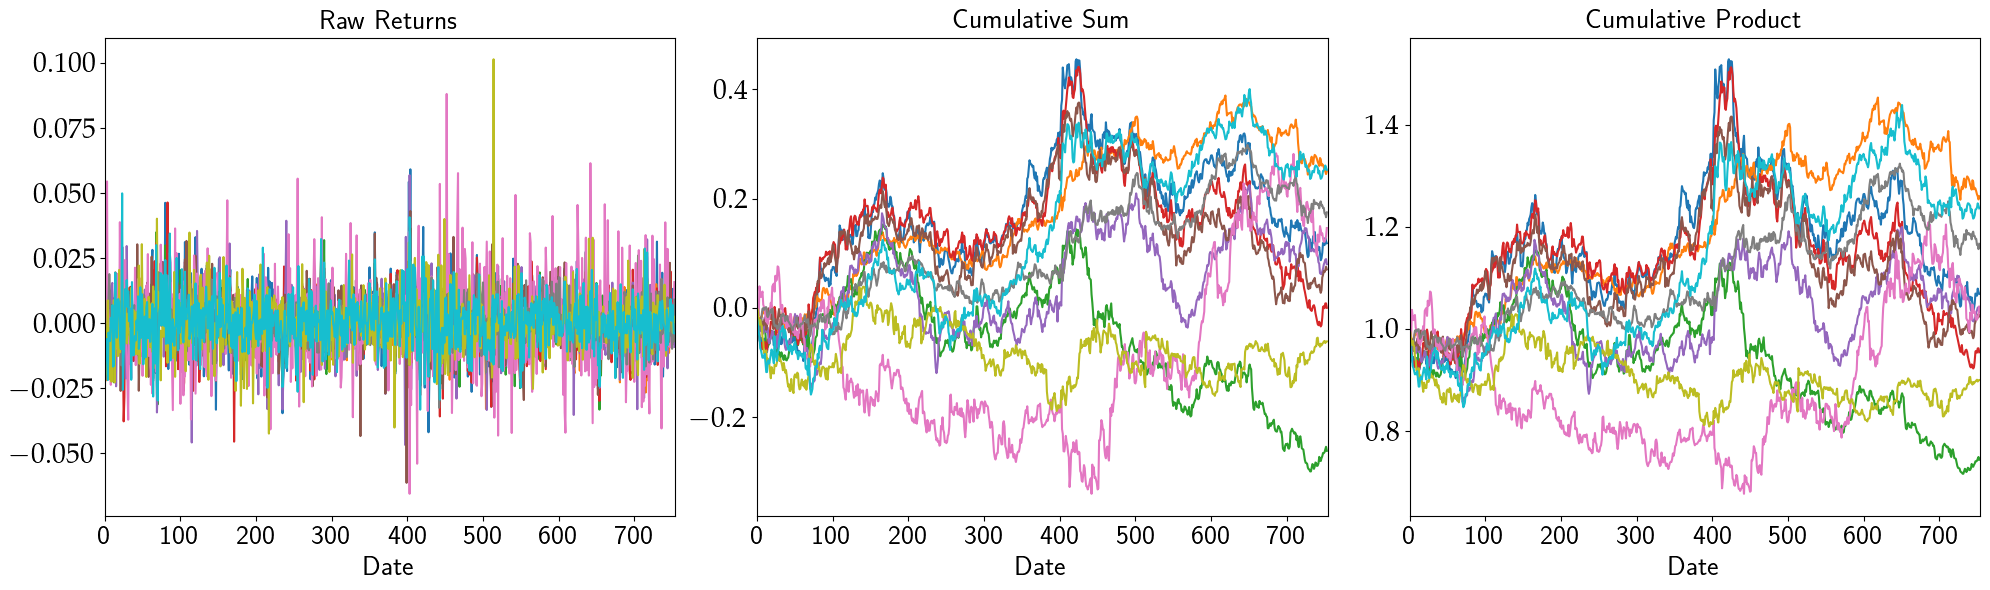

In [ ]:
# Create a single figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
X_train_df.iloc[0:10].T.plot(ax=axes[0], legend=False)
X_train_df.iloc[0:10].T.cumsum().plot(ax=axes[1], legend=False)
(1.0 + X_train_df.iloc[0:10]).T.cumprod().plot(ax=axes[2], legend=False)

axes[0].set_title("Raw Returns", fontsize=fontSize)
axes[0].set_xlabel(r'Date', fontsize=fontSize)
axes[0].tick_params(axis='x', labelsize=fontSize)
axes[0].tick_params(axis='y', labelsize=fontSize)
axes[0].set_xlim(0, X_train_df.shape[1])

axes[1].set_title("Cumulative Sum", fontsize=fontSize)
axes[1].set_xlabel(r'Date', fontsize=fontSize)
axes[1].tick_params(axis='x', labelsize=fontSize)
axes[1].tick_params(axis='y', labelsize=fontSize)
axes[1].set_xlim(0, X_train_df.shape[1])

axes[2].set_title("Cumulative Product", fontsize=fontSize)
axes[2].set_xlabel(r'Date', fontsize=fontSize)
axes[2].tick_params(axis='x', labelsize=fontSize)
axes[2].tick_params(axis='y', labelsize=fontSize)
axes[2].set_xlim(0, X_train_df.shape[1])

plt.tight_layout()
# plt.savefig(f'plots/stocks.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## Generate time-lagged returns

In [149]:
def create_time_lagged(dataframe: pd.DataFrame, lag: int = 250) -> pd.DataFrame:
    """
    Create a time-lagged dataframe for estimating beta in the factor model.

    Given a stock returns dataframe of shape (m x T), this function transforms it into a
    time-lagged format where each row represents (stock, time) pairs and each column contains
    the lagged return values for that stock.

    For each stock s at time t, we construct a time-lagged feature vector:

        X_t = [r_{t-1}, r_{t-2}, ..., r_{t-D}]

    where D is the lag window.

    Final Shape:
        - Input: (m x T)
        - Output: ((T - D) x m) x D

    Args:
        dataframe (pd.DataFrame): A DataFrame of shape (m x T), where:
                                  - m: number of stocks
                                  - T: number of time periods (dates)
        lag (int, optional): The number of past time steps (default = 250).

    Returns:
        pd.DataFrame: A transformed DataFrame of shape ((T - D) x m) x D, where:
                      - Each row represents (stock, time) pairs.
                      - Each column represents time-lagged return values.
    """
    df = dataframe.copy()

    # Create lagged features: shift each row (transposed DataFrame) and stack into a long format
    # Stacking -> (504, 50, 250) -> (25200, 250)
    df_lagged = pd.concat([df.T.shift(i + 1).stack(future_stack=True) for i in range(lag)], axis=1).dropna()

    # Set column names as time lags (1 to L)
    df_lagged.columns = pd.RangeIndex(start=1, stop=lag + 1, name="timeLag")

    return df_lagged

In [150]:
X_train = create_time_lagged(X_train_df, lag = 250)

In [151]:
print(f'The shape of the time-lagged return values is {X_train.shape}')

The shape of the time-lagged return values is (25200, 250)


## Predicting Stock Returns with a Linear Factor Model

Consider a stock market with $m$ stocks. Let the vector of stock returns at time $t$ be:

$$
R_t \in \mathbb{R}^m
$$

The objective is to construct, at each time $t$, a prediction vector:

$$
S_{t+1} \in \mathbb{R}^m
$$

using only the information available up to time $t$, such that the **prediction overlap** — the inner product between the predicted and actual returns — is frequently positive:

$$
\langle S_{t+1}, R_{t+1} \rangle > 0
$$

Achieving this consistently is challenging. To tackle this problem, we adopt a **linear factor model**, where the factors are learned over a structured, potentially non-linear, parameter space.

---

## Linear Factor Model

The simplest and most common approach involves using a **parametric model** of the form:

$$
S_{t+1} = \sum_{\ell=1}^{F} \beta_{\ell} F_{t, \ell}
$$

where:

- $F$ is the number of factors.
- $F_{t, \ell} \in \mathbb{R}^m$ is the $\ell$-th explanatory factor (or feature vector) at time $t$. These factors are typically crafted using financial expertise.
- $\beta \in \mathbb{R}^F$ is a vector of model parameters $(\beta_1, \beta_2, \dots, \beta_F)$ that need to be learned from historical data.

In matrix form, this can be compactly written as:

$$
S_{t+1} = F_t \beta
$$

where:

- $F_t \in \mathbb{R}^{m \times F}$ is the matrix whose columns are the factor vectors $F_{t, \ell}$.
- $\beta \in \mathbb{R}^F$ is the parameter vector.
- $S_{t+1} \in \mathbb{R}^m$ is the predicted return vector.

The goal is to learn $\beta$ using a training dataset $(R_t, F_t)$.

### Designing the Factors $F_{t, \ell}$

The key question in building a factor model is: **how should we design the factors $F_{t, \ell}$**  

#### Commonly Used Factors in Trading

The normalised mean return, $R_{t}^{p}$ is defined as:

$$
R_{t}^{(p)} = \dfrac{1}{\sqrt{p}}\sum_{k=1}^{p}R_{t+1-k}
$$

Some well-known factors in trading include:

1) **5-day normalized mean return**:
   
   $$
   R_t^{(5)} = \dfrac{1}{\sqrt{5}}\sum_{k=1}^{5}R_{t+1-k}
   $$

   which computes the average return over the last 5 days.
   
2) **Momentum Factor**:
   
   $$
   M_t = R_{t-20}^{(230)}
   $$

   which represents the return from 20 days ago over a 230-day period.

If one has no prior financial knowledge but aims to develop a mathematically principled approach, a natural idea is to **learn the factors themselves** within the simplest class of factors: **linear functions of past returns**.

#### Learning Factors as Linear Combinations of Past Returns
We define the factors as weighted sums of past returns:

$$
F_{t, \ell} = \sum_{k=1}^{D} A_{k\ell} R_{t+1-k}
$$

where:
- $A_{\ell} = A_{k\ell} \in \mathbb{R}^D$ are **learnable factor weight vectors**.
- $D$ is a **fixed time depth parameter**, determining how far back in time we look for information.

#### Ensuring Independence Between Factors

To avoid redundancy, we enforce the factors to be **independent** by assuming that the weight vectors $A_{\ell}$ are **orthonormal**:

$$
\langle A_k, A_\ell \rangle = \delta_{kl}, \quad \forall k, \ell
$$

where $\delta_{kl}$ is the Kronecker delta. This introduces a **non-linear constraint** into the parameter space of the model.

---

### Final Predictive Model Parameters
We now have a **parametric predictive model** with the following parameters:

1. **Factor Loading Matrix $\mathbf{A}$**:
   
   $$
   \mathbf{A} = [\mathbf{A}_1, \dots, \mathbf{A}_F] \in \mathbb{R}^{D \times F}
   $$
   where $\mathbf{A}$ has **orthonormal columns**.

2. **Factor Coefficients $\beta$**:
   
   $$
   \beta = (\beta_1, \dots, \beta_F) \in \mathbb{R}^F
   $$

   which represents the weights assigned to each factor.

---

### Connection to Known Models
This framework naturally generalizes existing models:
- It includes the **two-factor model** using $R_t^{(5)}$  and $M_t$.
- It generalizes the **autoregressive (AR) model** from time-series analysis.

Thus, by **learning the factors directly from data**, we create a **flexible** yet **interpretable** model for stock return prediction.

## Factor Model Design and Evaluation

We allow $D = 250$ days for the time depth and $F = 10$ for the number of factors.

### Metric Definition

To assess the quality of the predictive model with parameters $(A, \beta)$, we define the evaluation metric as follows. Let $\tilde{R}_t \in \mathbb{R}^{50}$ represent the returns of the 50 stocks in the testing dataset over the three-year period $(t = 0, \dots, 753)$. Let $\tilde{S}_t = \tilde{S}_t(A, \beta)$ be the predicted returns for $\tilde{R}_t$ using the given model. The objective is to maximize the following metric:

$$
\text{Metric}(A, \beta) := \frac{1}{504} \sum_{t=250}^{753} \frac{\langle \tilde{S}_t, \tilde{R}_t \rangle}{\| \tilde{S}_t \| \| \tilde{R}_t \|}
$$

where $\langle \tilde{S}_t, \tilde{R}_t \rangle$ denotes the inner product between the predicted and actual returns, and $\| \tilde{S}_t \|$ and $\| \tilde{R}_t \|$ are their respective norms.

### Orthonormality Condition

To ensure the factors remain independent, the columns of matrix $A$ must satisfy the approximate orthonormality condition:

$$
| \langle A_i, A_j \rangle - \delta_{ij} | \leq 10^{-6}, \quad \forall i, j.
$$

If this condition is violated for any pair $(i, j)$, the metric is assigned a value of:

$$
\text{Metric}(A, \beta) := -1.
$$

### Interpretation

By design, the metric takes values in the range $[-1,1]$. It equals $-1$ if any pair $(i, j)$ of factors violates the orthonormality constraint beyond the threshold, ensuring that the model adheres to structural requirements while optimizing predictive performance.

## Finding $\beta$

Mathematically, we solve for $\beta$ in:

$$
\beta = (\mathbf{F}^T \mathbf{F})^{-1} \mathbf{F}^T \mathbf{Y}
$$

where:
- $\mathbf{{F}} = \mathbf{X} \mathbf{A}$ is the transformed feature matrix of shape $((T - D) \times m) \times F$. 
- $\mathbf{X}\in\mathbb{R}^{((T-D)\times m) \times D}$ and $\mathbf{A}\in\mathbb{R}^{D\times F}$. 
- $\mathbf{Y}$ is the stacked target matrix of shape $(T - D) \times m$
- $\beta$ is the factor loading matrix of shape $F$


In [156]:
def check_orthonormality(matrix_A: pd.DataFrame) -> bool:
    """
    Checks whether the given matrix is orthonormal.

    A matrix is considered orthonormal if its columns are orthonormal vectors, meaning:

    1. Each column vector has unit norm.
    2. Each pair of distinct column vectors is orthogonal.

    This function computes the Gram matrix and compares it with the identity matrix,
    ensuring that the absolute difference between them is within a given tolerance (1e-6).

    Args:
        matrix_A (pd.DataFrame): A DataFrame representing a matrix of shape (D, F),
            where D is the time depth and F is the number of factors.

    Returns:
        bool: True if the matrix is orthonormal, False otherwise.
    """
    # Compute the Gram matrix (A^T A)
    gram_matrix = matrix_A.T @ matrix_A

    # Compute the difference from the identity matrix
    deviation = np.abs(gram_matrix - np.eye(matrix_A.shape[1]))

    # Check if any deviation exceeds the tolerance
    return not (deviation > 1e-6).any().any()

def fit_beta(matrix_A: pd.DataFrame, x_train: pd.DataFrame, y_train: pd.DataFrame) -> np.ndarray:
    """
    Compute the optimal beta values for a linear factor model using least squares regression.

    Given an orthonormal matrix A, time-lagged features, and corresponding stock returns,
    this function estimates the factor loadings (beta) by solving the normal equations
    for ordinary least squares.

    Args:
        matrix_A (pd.DataFrame): Orthonormal matrix of shape (D, F), where D is the time depth and F is the number of factors.
        x_train (pd.DataFrame): Feature matrix of shape ((T - D) * m, D), where T is the number of time periods and m is the number of stocks.
        y_train (pd.DataFrame): Target matrix of shape (m, T - D), representing stock returns.

    Returns:
        np.ndarray: Estimated beta values of shape (F, 1), representing the factor loadings.
    """
    # Compute transformed features matrix of shape ((T - D) * m, F)
    factors = x_train @ matrix_A

    # Stack target matrix Y into a vector of shape (m * (T - D), 1)
    targets = y_train.T.stack()

    # Solve for beta using the normal equation
    beta = np.linalg.inv(factors.T @ factors) @ factors.T @ targets

    return beta.to_numpy()

def calculate_metric(matrix_A: np.ndarray, beta_opt: np.ndarray, x_train: pd.DataFrame, y_train: pd.DataFrame) -> float:
    """Calculate a metric similar to cosine similarity between predicted and true values.

    Args:
        matrix_A (np.ndarray): Orthonormal matrix of shape (D, F), where D is the time depth and F is the number of factors.
        beta_opt (np.ndarray): Optimal beta values of shape (F,).
        x_train (pd.DataFrame): Feature matrix of shape ((T - D) * m, D), where T is the number of time periods and m is the number of stocks.
        y_train (pd.DataFrame): Target matrix of shape (m, T - D), representing stock returns.

    Returns:
        float: The calculated similarity metric, or -1.0 if the matrix is not orthonormal.
    """

    # Check orthonormality of matrix_A
    if not check_orthonormality(matrix_A):
        return -1.0

    # Compute predicted values Ypred
    y_pred = (x_train @ matrix_A @ beta_opt).unstack().T
    y_true = y_train

    # Normalize the true and predicted values to unit vectors (L2 normalization)
    y_true = y_true.div(np.sqrt((y_true**2).sum()), 1)
    y_pred = y_pred.div(np.sqrt((y_pred**2).sum()), 1)

    # Calculate the mean overlap (cosine similarity)
    mean_overlap = (y_true * y_pred).sum().mean()

    return mean_overlap

def generate_A(lag: int = 250, nfactors: int = 10) -> np.ndarray:
    """
    Generates a random matrix and applies the Gram-Schmidt process
    to obtain an orthonormal basis (Stiefel manifold).

    Args:
        lag (int, optional): The number of rows in the generated matrix. Defaults to 250.
        nfactors (int, optional): The number of columns (factors) in the generated matrix. Defaults to 10.

    Returns:
        np.ndarray: An orthonormal matrix of shape (lag, nfactors).
    """
    matrix = np.random.randn(lag, nfactors)
    random_stiefel = np.linalg.qr(matrix)[0]  # Apply Gram-Schmidt algorithm to orthogonalize the columns

    return random_stiefel

def parameters_transform(
    matrix_A: np.ndarray,
    beta: np.ndarray,
    lag: int = 250,
    nfactors: int = 10,
    save: bool = False,
    fname: str = 'submissionExample'
) -> np.ndarray:
    """
    Transforms the factor loading matrix and beta vector into a single vertically stacked column vector.

    Args:
        matrix_A (np.ndarray): Factor loading matrix of shape (lag, nfactors).
        beta (np.ndarray): Factor beta vector of shape (nfactors, 1) or (nfactors,).
        lag (int, optional): Number of time lags (default: 250).
        nfactors (int, optional): Number of factors (default: 10).
        save (bool, optional): Option to save the dataframe. Defaults to False.
        fname (str, optional): Filename to save the dataframe. Defaults to 'submissionExample'.

    Returns:
        np.ndarray: A vertically stacked column vector of shape (lag * nfactors + nfactors, 1) = (2510, 1).

    Raises:
        ValueError: If matrix_A does not have shape (lag, nfactors).
        ValueError: If beta does not have shape (nfactors, 1) or (nfactors,).
    """
    # Validate input shapes
    if matrix_A.shape != (lag, nfactors):
        raise ValueError(f"matrix_A must have shape ({lag}, {nfactors}), but got {matrix_A.shape}.")

    if beta.shape not in [(nfactors, 1), (nfactors,)]:
        raise ValueError(f"beta must have shape ({nfactors}, 1) or ({nfactors},), but got {beta.shape}.")

    # Ensure beta is a column vector
    beta = beta.reshape(nfactors, 1)

    # Flatten matrix_A row-wise and stack with beta
    output = np.hstack((np.hstack([matrix_A.T, beta])).T )

    # store the output
    if save:
        pd.DataFrame(output).to_csv(f'submissions/{fname}.csv')

    return output

## Find the Factors (QRT)

This is by brute force method. 

In [8]:
def optimisation(
    x_train: np.ndarray,
    y_train: np.ndarray,
    ntrial: int = 1000,
    lag: int = 250,
    nfactors: int = 10
) -> tuple[np.ndarray, np.ndarray]:
    """
    Optimizes the selection of matrix A and corresponding beta by iterating over multiple trials
    to maximize a given metric.

    Args:
        x_train (np.ndarray): The training input data. This is of size (T-D)*m x D
        y_train (np.ndarray): The training target data. This is of size m x (T-D)
        ntrial (int, optional): The number of trials for optimization. Defaults to 1000.
        lag (int, optional): The number of rows in the generated matrix A. Defaults to 250.
        nfactors (int, optional): The number of columns (factors) in the generated matrix A. Defaults to 10.

    Returns:
        tuple[np.ndarray, np.ndarray]: The optimized matrix A (`matrix_A_qrt`) and corresponding beta (`beta_qrt`).
    """
    max_metric = -1.0
    matrix_A_qrt, beta_qrt = None, None

    for i in range(ntrial):
        matrix_A = generate_A(lag, nfactors)
        beta = fit_beta(matrix_A, x_train, y_train)
        metric = calculate_metric(matrix_A, beta, x_train, y_train)

        if metric > max_metric:
            print(f'Metric for iteration {i:3d} is {metric:.5f}')
            max_metric = metric
            matrix_A_qrt = matrix_A
            beta_qrt = beta

    return matrix_A_qrt, beta_qrt

In [316]:
matrix_A_qrt, beta_qrt = optimisation(X_train, Y_train)

Metric for iteration   0 is 0.01994
Metric for iteration   1 is 0.03689
Metric for iteration   5 is 0.03906
Metric for iteration   6 is 0.03975
Metric for iteration  25 is 0.04107
Metric for iteration 120 is 0.04766
Metric for iteration 603 is 0.05168


In [ ]:
# submission_qrt = parameters_transform(matrix_A_qrt, beta_qrt, save=True, fname = 'submission_qrt')

## My Analytical Approach

$$
\mathbf{Y} = \mathbf{X}\mathbf{A} \beta 
$$

Therefore, we can rewrite the above as:

$$
(\mathbf{X}^{\textrm{T}}\mathbf{X})^{-1}\mathbf{X}^{\textrm{T}}\mathbf{Y} = \mathbf{A}\beta
$$

and hence, the known vector $\mathbf{r}$ is:

$$
\mathbf{r} = \mathbf{A}\beta.
$$

In terms of the covariance of the above, we have 

$$
\mathbf{C}_{r} = \mathbf{A}\mathbf{C}_{\beta}\mathbf{A}^{\textrm{T}}
$$

We can find the matrix $\mathbf{A}$ using singular value decomposition (SVD), that is, 

$$
\textrm{svd}(\mathbf{C}_{r}) = \mathbf{U}\mathbf{D}\mathbf{V}^{\textrm{T}}
$$

where $\mathbf{U}=\mathbf{A}$, an orthornomal matrix.  

In [10]:
def analytical_solution(
    x_train: pd.DataFrame,
    y_train: pd.DataFrame,
    nfactors: int = 10
) -> tuple[np.ndarray, np.ndarray]:
    """
    Computes the analytical solution for factor decomposition using Singular Value Decomposition (SVD).

    Args:
        x_train (pd.DataFrame):
            Feature matrix of shape ((T - D) * m, D), where:
            - T: Number of time periods.
            - D: Time depth (lookback window).
            - m: Number of stocks.
        y_train (pd.DataFrame):
            Target matrix of shape (m, T - D), where each row represents the time series of a stock.
        nfactors (int, optional):
            Number of factors to retain. Defaults to 10.

    Returns:
        tuple[np.ndarray, np.ndarray]:
            - my_matrix_A (np.ndarray): The factor loading matrix of shape (D, nfactors).
            - my_beta (np.ndarray): The factor betas of shape (nfactors,).
    """
    # Compute the least squares solution for factor returns
    vector_r = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train.T.stack()

    # Convert vector_r to a NumPy array and reshape it to a column vector
    vector_r = vector_r.to_numpy().reshape(-1, 1)

    # Compute the covariance matrix of factor returns
    cov_r = vector_r @ vector_r.T

    # Perform Singular Value Decomposition (SVD)
    U_matrix, D_vector, Vt_matrix = np.linalg.svd(cov_r, full_matrices=True)

    # Extract the top nfactors eigenvectors as the factor loading matrix
    my_matrix_A = U_matrix[:, :nfactors]

    # Compute the factor betas
    my_beta = my_matrix_A.T @ vector_r

    # Evaluate the model performance using a custom metric
    my_metric = calculate_metric(my_matrix_A, my_beta, x_train, y_train)
    print(f"Metric using analytical method: {my_metric:.5f}")

    return my_matrix_A, my_beta

In [11]:
my_matrix_A, my_beta = analytical_solution(X_train, Y_train)

Metric using analytical method: 0.13319


In [12]:
# output = parameters_transform(my_matrix_A, my_beta, save = True)

In [13]:
def df_to_3d_tensor(df: pd.DataFrame) -> np.ndarray:
    """
    Converts a MultiIndex DataFrame (date, stocksID) into a 3D NumPy tensor.

    Args:
        df (pd.DataFrame): DataFrame with MultiIndex (date, stocksID).

    Returns:
        np.ndarray: 3D tensor of shape (504, 50, num_features).
    """

    # Extract unique dates and stocks
    unique_dates = df.index.get_level_values('date').unique()
    unique_stocks = df.index.get_level_values('stocksID').unique()

    # Convert to 3D array
    tensor = df.values.reshape(len(unique_dates), len(unique_stocks), -1)

    return tensor

In [14]:
factors = X_train @ my_matrix_A
factors_reshaped = df_to_3d_tensor(factors)

In [15]:
print(f'The shape of the factors is {factors.shape}')
print(f'The shape of the factors (reshaped) is {factors_reshaped.shape}')

The shape of the factors is (25200, 10)
The shape of the factors (reshaped) is (504, 50, 10)


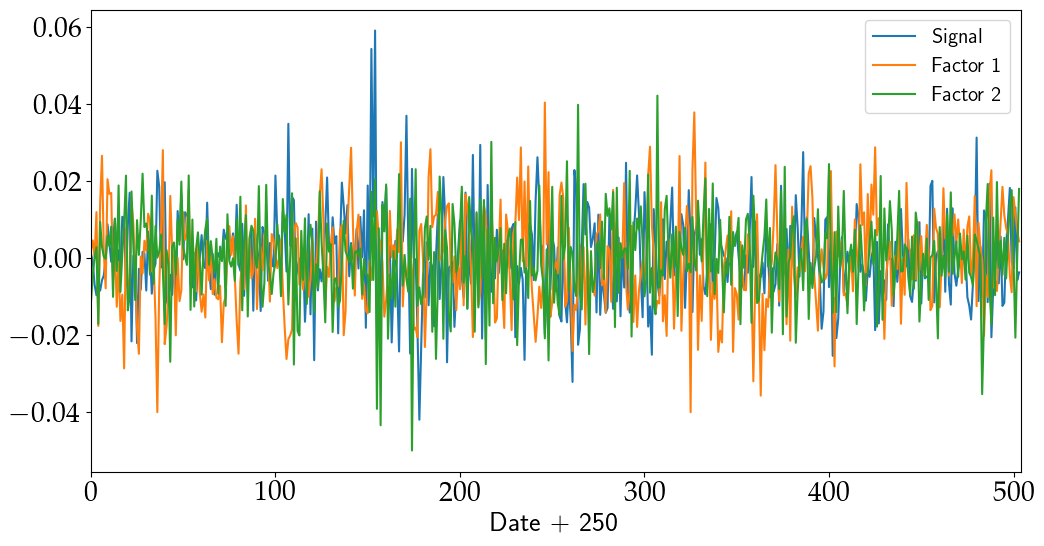

In [ ]:
stock_index = 0
plt.figure(figsize=(12,6))
plt.plot(Y_train.iloc[stock_index].values, label = 'Signal')
plt.plot(factors_reshaped[:, stock_index, :,][:,0], label = 'Factor 1')
plt.plot(factors_reshaped[:, stock_index, :,][:,1], label = 'Factor 2')
plt.xlim(0,504)
plt.xlabel(r'Date + 250', fontsize=fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
# plt.savefig('plots/factors_stock_0.pdf', bbox_inches = 'tight')
plt.show()

## The two factor model using '5-day returns' and 'momentum'

This model to be implemented is as follows:

$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$

where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

In [136]:
def calculate_rolling_mean(
    df: pd.DataFrame,
    window: int,
    time_lag: int,
    last_t: int = None
) -> pd.DataFrame:
    """
    Computes the rolling mean of the input DataFrame with a given time lag and scaling factor.

    Args:
        df (pd.DataFrame): Input DataFrame of size Txm (m is the number of stock) where rows represent time periods.
        window (int): Rolling window size for computing the mean.
        time_lag (int): Time shift applied before computing the rolling mean.
        last_t (int, optional): If provided, returns only the last `last_t` rows.

    Returns:
        pd.DataFrame: Transformed DataFrame with rolling mean applied, scaled by sqrt(window).
    """
    df_new = df.copy()

    # Compute rolling mean after shifting by time_lag
    factor = df_new.shift(time_lag).rolling(window).mean() * np.sqrt(window)

    # Replace NaN values with 0
    factor.fillna(0, inplace=True)

    # Return only the last `last_t` rows if specified
    return factor.iloc[-last_t:] if last_t is not None else factor

## Rolling Volatility

$$
\sigma_{t}^{(n)} = \sqrt{\dfrac{1}{n}\sum_{k=1}^{n}(R_{t+1-k} - \bar{R})^{2}}
$$

In [137]:
def calculate_rolling_volatility(
    df: pd.DataFrame, window: int, last_t: int = None
) -> pd.DataFrame:
    """Calculates the rolling volatility (standard deviation) of a given DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing time-series data.
        window (int): The window size for calculating rolling standard deviation.
        last_t (int, optional): If provided, returns only the last `last_t` rows of the result.

    Returns:
        pd.DataFrame: DataFrame containing the rolling volatility values.
    """
    df_new = df.copy()
    factor = df_new.rolling(window=window).std()
    factor.fillna(0, inplace=True)
    return factor.iloc[-last_t:] if last_t is not None else factor

## Rolling Downside Volatility

$$
\sigma_{d}(t) = \sqrt{\dfrac{1}{N}\sum_{k=1}^{k}\textrm{min}(R_{t+1-k},0)^{2}}
$$

In [138]:
def calculate_rolling_downside_volatility(df: pd.DataFrame, window: int, last_t: int = None) -> pd.DataFrame:
    """
    Computes the rolling downside volatility for each stock in the DataFrame.

    Args:
        df (pd.DataFrame): A (T × m) DataFrame where T is the number of time periods and m is the number of stocks.
        window (int): The rolling window size for downside volatility calculation.
        last_t (int, optional): If provided, returns only the last `last_t` rows.

    Returns:
        pd.DataFrame: A DataFrame of shape (T × m) containing downside volatility values.
    """
    df_new = df.copy()
    downside_vol = df_new.rolling(window=window).apply(lambda x: np.sqrt(np.mean(np.minimum(x, 0) ** 2)), raw=True)
    downside_vol.fillna(0, inplace=True)  # Replace NaNs with 0

    return downside_vol.iloc[-last_t:] if last_t is not None else downside_vol

## Rolling Upside Volatility

$$
\textrm{Upside Volatility} = \sqrt{\dfrac{1}{N}\sum_{i=t-N+1}^{t}(R_{i}-\bar{R})^{2}}
$$

where $R_{i}>0$.

In [139]:
def calculate_rolling_upside_volatility(df: pd.DataFrame, window: int, last_t: Optional[int] = None) -> pd.DataFrame:
    """Calculates the rolling upside volatility of a given DataFrame over a specified window.

    The rolling upside volatility is computed as the standard deviation of only the positive values
    within the rolling window.

    Args:
        df (pd.DataFrame): The input DataFrame containing numerical data.
        window (int): The window size over which to compute the rolling upside volatility.
        last_t (Optional[int], optional): If specified, returns only the last `last_t` rows of the result. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling upside volatility values.
    """
    df_new = df.copy()
    upside_vol = df_new.rolling(window=window).apply(lambda x: np.std(x[x > 0]), raw=True)
    upside_vol.fillna(0, inplace=True)
    return upside_vol.iloc[-last_t:] if last_t is not None else upside_vol

## Rolling Skewness

$$
\textrm{Skewness} = \dfrac{\mathbb{E}[(X-\mu)^{3}]}{\sigma^{3}}
$$

In [140]:
def calculate_rolling_skewness(df: pd.DataFrame, window: int, last_t: Optional[int] = None) -> pd.DataFrame:
    """Calculates the rolling skewness of a given DataFrame over a specified window.

    Args:
        df (pd.DataFrame): The input DataFrame containing numerical data.
        window (int): The window size over which to compute the rolling skewness.
        last_t (Optional[int], optional): If specified, returns only the last `last_t` rows of the result. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling skewness values.
    """
    df_new = df.copy()
    factor = df_new.rolling(window=window).apply(lambda x: pd.Series(x).skew(), raw=True)
    factor.fillna(0, inplace=True)
    return factor.iloc[-last_t:] if last_t is not None else factor

## Rolling Kurtosis

$$
\textrm{Kurtosis} = \dfrac{\mathbb{E}[(X-\mu)^{4}]}{\sigma^{4}}
$$

In [141]:
def calculate_rolling_kurtosis(df: pd.DataFrame, window: int, last_t: Optional[int] = None) -> pd.DataFrame:
    """Calculates the rolling kurtosis of a given DataFrame over a specified window.

    Args:
        df (pd.DataFrame): The input DataFrame containing numerical data.
        window (int): The window size over which to compute the rolling kurtosis.
        last_t (Optional[int], optional): If specified, returns only the last `last_t` rows of the result. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling kurtosis values.
    """
    df_new = df.copy()
    factor = df_new.rolling(window=window).apply(lambda x: kurtosis(x, bias=False), raw=True)
    factor.fillna(0, inplace=True)
    return factor.iloc[-last_t:] if last_t is not None else factor

## Rolling Sharpe Ratio

$$
\textrm{Sharpe Ratio} = \dfrac{\mathbb{E}[R_{t}-r_{f}]}{\sigma}
$$

In [142]:
def calculate_rolling_sharpe_ratio(df: pd.DataFrame,
                                   window: int,
                                   risk_free_rate: float = 0,
                                   last_t: Optional[int] = None) -> pd.DataFrame:
    """Calculates the rolling Sharpe ratio of a given pd.DataFrame over a specified window.

    The Sharpe ratio is computed as the rolling mean of excess returns divided by the rolling
    standard deviation of excess returns.

    Args:
        df (pd.DataFrame): The input DataFrame of size (754, 50) containing numerical data.
        window (int): The window size over which to compute the rolling Sharpe ratio.
        risk_free_rate (float, optional): The risk-free rate to subtract from returns. Defaults to 0.
        last_t (Optional[int], optional): If specified, returns only the last `last_t` rows of the result. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling Sharpe ratio values.
    """
    df_new = df.copy()
    excess_return = df - risk_free_rate
    sharpe_ratio = excess_return.rolling(window=window).mean() / excess_return.rolling(window=window).std()
    sharpe_ratio.fillna(0, inplace=True)
    return sharpe_ratio.iloc[-last_t:] if last_t is not None else sharpe_ratio

## Rolling Sortino Ratio

In [143]:
def calculate_rolling_sortino_ratio(df: pd.DataFrame,
                                    window: int,
                                    risk_free_rate: float = 0,
                                    last_t: Optional[int] = None) -> pd.DataFrame:
    """Calculates the rolling Sortino ratio of a given DataFrame over a specified window.

    The Sortino ratio is computed as the rolling mean of excess returns divided by the rolling
    downside volatility, which considers only negative deviations from the risk-free rate.

    Args:
        df (pd.DataFrame): The input DataFrame containing numerical data.
        window (int): The window size over which to compute the rolling Sortino ratio.
        risk_free_rate (float, optional): The risk-free rate to subtract from returns. Defaults to 0.
        last_t (Optional[int], optional): If specified, returns only the last `last_t` rows of the result. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling Sortino ratio values.
    """
    df_new = df.copy()
    excess_return = df_new - risk_free_rate
    downside_vol = calculate_rolling_downside_volatility(excess_return, window)
    sortino_ratio = excess_return.rolling(window=window).mean() / downside_vol
    sortino_ratio.fillna(0, inplace=True)
    return sortino_ratio.iloc[-last_t:] if last_t is not None else sortino_ratio

## Rolling Omega Ratio

In [144]:
def calculate_rolling_omega_ratio(df: pd.DataFrame, window: int, last_t: Optional[int] = None) -> pd.DataFrame:
    """Calculates the rolling Omega ratio of a given DataFrame over a specified window.

    The Omega ratio is computed as the sum of positive returns divided by the absolute sum of negative returns
    within the rolling window.

    Args:
        df (pd.DataFrame): The input DataFrame containing numerical data.
        window (int): The window size over which to compute the rolling Omega ratio.
        last_t (Optional[int], optional): If specified, returns only the last `last_t` rows of the result. Defaults to None.

    Returns:
        pd.DataFrame: A DataFrame containing the rolling Omega ratio values.
    """
    df_new = df.copy()
    rolling_pos = df_new.rolling(window).apply(lambda x: np.sum(x[x > 0]), raw=True)
    rolling_neg = df_new.rolling(window).apply(lambda x: np.abs(np.sum(x[x < 0])), raw=True)
    omega_ratio = (rolling_pos / rolling_neg)
    omega_ratio.fillna(0, inplace=True)
    return omega_ratio.iloc[-last_t:] if last_t is not None else omega_ratio

## Create Factors

In [145]:
return_5 = calculate_rolling_mean(X_train_df.T, window=5, time_lag=0, last_t=504)
momentum = calculate_rolling_mean(X_train_df.T, window=230, time_lag=20, last_t=504)
volatility = calculate_rolling_volatility(X_train_df.T, window=250, last_t=504)
downside_volatility = calculate_rolling_downside_volatility(X_train_df.T, window=250, last_t=504)
upside_volatility = calculate_rolling_upside_volatility(X_train_df.T, window=250, last_t=504)
skewness = calculate_rolling_skewness(X_train_df.T, window=250, last_t=504)
kurtosis = calculate_rolling_kurtosis(X_train_df.T, window=250, last_t=504)
sharpe_ratio = calculate_rolling_sharpe_ratio(X_train_df.T, window=250, last_t=504)
sortino_ratio = calculate_rolling_sortino_ratio(X_train_df.T, window=250, last_t=504)
omega_ratio = calculate_rolling_omega_ratio(X_train_df.T, window=250, last_t=504)

In [146]:
def create_factors_df(factors: list[pd.DataFrame], names: list[str]) -> pd.DataFrame:
    """
    Creates a DataFrame from a list of factors with corresponding names.

    Args:
        factors (list[pd.DataFrame]): A list of DataFrames containing factor values.
        names (list[str]): A list of factor names.

    Returns:
        pd.DataFrame: A DataFrame containing the factors with corresponding names.
    """
    factors_df = pd.concat(factors, axis=1)
    factors_df.columns = names
    return factors_df

In [147]:
factors = [return_5.stack(),
           momentum.stack(),
           volatility.stack(),
           downside_volatility.stack(),
           upside_volatility.stack(),
           skewness.stack(),
           kurtosis.stack(),
           sharpe_ratio.stack(),
           sortino_ratio.stack(),
           omega_ratio.stack()]

factor_names = ['return_5',
                'momentum',
                'volatility',
                'downside_volatility',
                'upside_volatility',
                'skewness',
                'kurtosis',
                'sharpe_ratio',
                'sortino_ratio',
                'omega_ratio']

factors_df = create_factors_df(factors, factor_names)

In [152]:
print(f'Shape of created factors is {factors_df.shape}')
print(f'Shape of X (time-lagged) is {X_train.shape}')

Shape of created factors is (25200, 10)
Shape of X (time-lagged) is (25200, 250)


In [153]:
def analytical_solution_factors(x_train: pd.DataFrame,
                                y_train: pd.DataFrame,
                                factors: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:

    # find matrix A
    matrix_A = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ factors

    # orthonormalize matrix A
    matrix_A_ortho = np.linalg.qr(matrix_A)[0]

    # check if matrix A is orthonormal
    if not check_orthonormality(matrix_A_ortho):
        raise ValueError("Matrix A is not orthonormal.")

    # find vector r
    vector_r = np.linalg.inv(x_train.T @ x_train) @ x_train.T @ y_train.T.stack()

    # find beta
    beta = matrix_A_ortho.T @ vector_r

    # evaluate the model performance using a custom metric
    my_metric = calculate_metric(matrix_A_ortho, beta, x_train, y_train)
    print(f"Metric using pre-built factors is: {my_metric:.5f}")

    return matrix_A_ortho, beta

In [154]:
A_method_2, beta_method_2 = analytical_solution_factors(X_train, Y_train, factors_df)

Metric using pre-built factors is: 0.02949


In [155]:
outputs_factors = parameters_transform(A_method_2, beta_method_2, save=True, fname = 'submission_factors')

# Bayesian Approach

In [10]:
def estimate_A_svd(x_train: np.ndarray, nlatent: int = 10) -> np.ndarray:
    """Estimate the matrix A using Singular Value Decomposition (SVD).

    Args:
        x_train (np.ndarray): Input data matrix of shape (N, D).
        nlatent (int): Number of latent components to retain.

    Returns:
        np.ndarray: Estimated A matrix of shape (D, nlatent).
    """
    U, S, Vt = np.linalg.svd(x_train, full_matrices=False)
    A_svd = Vt.T[:, :nlatent]  # Extract first nlatent singular vectors

    return A_svd

In [146]:
def model_with_a(x_train: jnp.ndarray,
          y_train: jnp.ndarray,
          a_matrix: jnp.ndarray,
          rate: float = 100.0,
          beta_width: float = 0.05) -> None:
    """Bayesian model with orthonormal latent variables for regression.

    This function defines a probabilistic model where the input features x_train
    are projected into a lower-dimensional latent space via an orthonormal matrix A.
    The model assumes a Gaussian likelihood for y_train with a latent linear structure.

    Args:
        x_train (jnp.ndarray): The input feature matrix of shape (N, D),
            where N is the number of data points and D is the number of features.
        y_train (jnp.ndarray): The observed target values of shape (N,).
        a_matrix (jnp.ndarray): The orthonormal matrix of shape (D, M),
            where M is the number of latent factors.
        rate (float, optional): The rate parameter for the Exponential prior on sigma.
            Defaults to 100.0.
        beta_width (float, optional): The scale parameter for the Normal prior on beta.

    Raises:
        ValueError: If x_train and y_train have incompatible shapes.

    Returns:
        None: This function defines a NumPyro model for inference.
    """
    nlatent = a_matrix.shape[1]

    # Prior on beta (M-dimensional vector)
    beta = numpyro.sample("beta", dist.Normal(0, beta_width).expand([nlatent]))

    # Compute predicted mean
    Y_hat = jnp.dot(x_train, jnp.dot(a_matrix, beta))

    # Likelihood (assuming Gaussian noise)
    sigma = numpyro.sample("sigma", dist.Exponential(rate))
    numpyro.sample("obs", dist.Normal(Y_hat, sigma), obs=y_train)

### Expenential distribution as a prior on $\sigma$

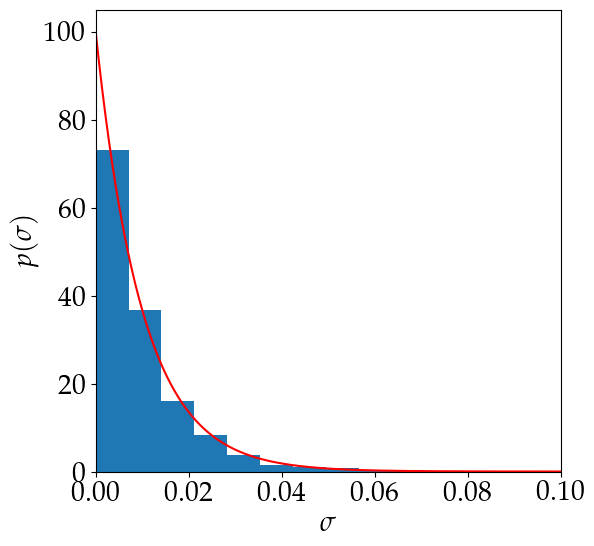

In [188]:
rate_value = 100.0
sigma_max = 0.1
sigma_grid = jnp.linspace(0, sigma_max, 1000)
sigma_samples = dist.Exponential(rate=rate_value).sample(random.PRNGKey(0), sample_shape=(1000,))
sigma_pdf = dist.Exponential(rate=rate_value).log_prob(sigma_grid)

plt.figure(figsize=(6,6))
plt.hist(sigma_samples, density = True)
plt.plot(sigma_grid, jnp.exp(sigma_pdf), color='red')
plt.ylabel(r'$p(\sigma)$', fontsize = fontSize)
plt.xlabel(r'$\sigma$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(0, sigma_max)
plt.show()

## Sampler

In [289]:
NWARMUP = 500
NSAMPLES = 5000
NCHAIN = 8

In [290]:
A_from_X = True
if A_from_X:
    estimated_matrix_A = estimate_A_svd(X_train.values)
    fname = 'svd_x'
else:
    estimated_matrix_A = my_matrix_A
    fname = 'cov_r'

In [291]:
nuts_kernel = NUTS(model_with_a)

mcmc = MCMC(nuts_kernel,
            num_warmup=NWARMUP,
            num_samples=NSAMPLES,
            num_chains=NCHAIN,
            chain_method="vectorized")

mcmc.run(random.PRNGKey(randint(0, 1000)), X_train.values, Y_train.T.stack().values, estimated_matrix_A)

sample: 100%|██████████| 5500/5500 [02:26<00:00, 37.59it/s]


In [ ]:
def get_mcmc_samples(mcmc: MCMC,
                     x_train: pd.DataFrame,
                     y_train: pd.DataFrame,
                     matrix_a: np.ndarray,
                     burnin: float = 0.1) -> Dict[str, jnp.ndarray]:
    """Extracts posterior samples from an MCMC run after applying burn-in.

    This function retrieves the posterior samples from a NumPyro MCMC object,
    discards the initial burn-in portion, and concatenates the remaining samples
    across chains. It also computes a custom metric for each posterior sample.

    Args:
        mcmc (MCMC): The NumPyro MCMC object containing the sampled posterior distributions.
        x_train (pd.DataFrame): The input feature matrix of shape (N, D).
        y_train (pd.DataFrame): The observed target values of shape (N,).
        matrix_a (np.ndarray): The orthonormal matrix of shape (D, M).
        burnin (float, optional): The fraction of initial samples to discard as burn-in.
            Defaults to 0.1 (i.e., 10% of the samples).

    Returns:
        Dict[str, jnp.ndarray]: A dictionary containing:
            - 'A': Posterior samples of the matrix A, concatenated across chains.
            - 'beta': Posterior samples of the parameter beta, concatenated across chains.
            - 'sigma': Posterior samples of the noise parameter sigma, concatenated across chains.
            - 'metric': Computed metrics for each posterior sample.
    """
    # Get the MCMC samples
    samples = mcmc.get_samples(group_by_chain=True)

    # Compute the burn-in steps
    burnin_steps = int(burnin * samples["beta"].shape[1])

    # Extract the posterior samples after burn-in
    samples_posterior = {k: v[:, burnin_steps:] for k, v in samples.items()}

    # Concatenate samples across chains
    beta_samples = jnp.concatenate(samples_posterior["beta"], axis=0)
    sigma_samples = jnp.concatenate(samples_posterior["sigma"], axis=0)

    # Compute custom metric for each sample
    record_metric = []
    for i in range(beta_samples.shape[0]):
        metric = calculate_metric(matrix_a, beta_samples[i], X_train, Y_train)
        record_metric.append(metric)

    record_metric = jnp.array(record_metric)
    pos_idx = record_metric > 0.0

    # Store results in a dictionary
    record = {
        "beta": beta_samples[pos_idx],
        "sigma": sigma_samples[pos_idx],
        "metric": record_metric[pos_idx],
        "A": matrix_a
    }

    return record

def dill_save(file: Any, folder: str, fname: str) -> None:
    """Stores a file, for example, MCMC samples.
    Args:
        file (Any): the file we want to store.
        folder (str): folder where we want to store the file
        fname (str): the name of the file.
    """
    os.makedirs(folder, exist_ok=True)
    # use compressed format to store data
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "wb") as dummy:
        dill.dump(file, dummy)


def dill_load(folder: str, fname: str) -> Any:
    """Reads a file from a folder.
    Args:
        folder(str): the name of the folder.
        file (str): the name of the file.
    Returns:
        Any: the stored file
    """
    path = os.path.join(folder, fname)
    with open(path + ".pkl", "rb") as dummy:
        file = dill.load(dummy)
    return file

In [293]:
record = get_mcmc_samples(mcmc, X_train, Y_train, estimated_matrix_A, burnin=0.10)

In [294]:
dill_save(record, 'samples', f'record_{fname}_{NCHAIN}_{NSAMPLES}')
dill_save(mcmc, 'samples', f'mcmc_{fname}_{NCHAIN}_{NSAMPLES}')

### Distribution of the Metric 

Calculated metric over all $\beta$. 

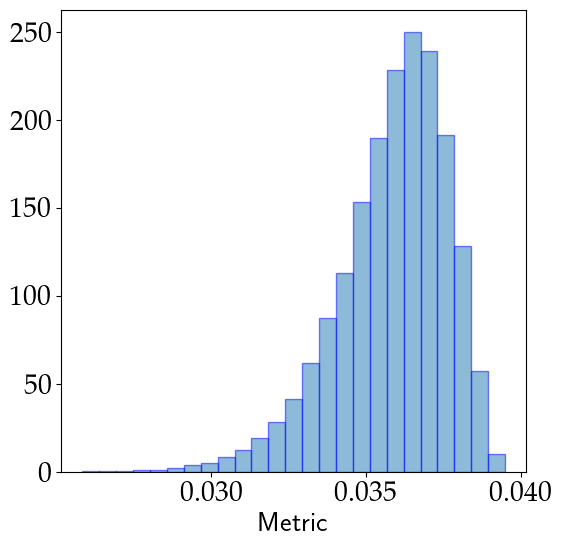

In [295]:
plt.figure(figsize=(6,6))
plt.hist(record['metric'], density=True, alpha = 0.5, bins = 25, edgecolor="blue")
plt.xlabel('Metric', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig(f'plots/metric_distribution_{fname}.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

## Marginalised Posterior of $\beta$

In [313]:
record_cov = dill_load('samples', 'record_cov_r_8_5000')
beta_sigma_samples = jnp.hstack([record_cov['beta'][:,0:5], record_cov['sigma'].reshape(-1, 1)])
fname = 'cov_r'

In [314]:
ndim = beta_sigma_samples.shape[1]
names = ["x%s"%i for i in range(ndim)]
labels =  [r'$\beta_{1}$', r'$\beta_{2}$', r'$\beta_{3}$', r'$\beta_{4}$', r'$\beta_{5}$', r'$\sigma$']
samples = MCSamples(samples=beta_sigma_samples, names = names, labels = labels)

Removed no burn in


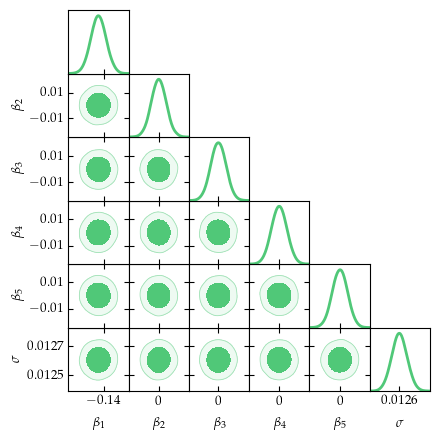

In [315]:
color1 = "#50C878"
G = plots.getSubplotPlotter(subplot_size=0.75)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.5
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35
G.settings.legend_fontsize = 15
samples.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot([samples],
    filled=[True],
    contour_colors=[color1],
    contour_lws=[2],
    contour_ls=["-"],
)
plt.savefig(f'plots/triangle_plot_{fname}.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

### Diagnostics

In [234]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -0.14      0.01     -0.14     -0.15     -0.13  82732.24      1.00
   beta[1]      0.00      0.01      0.00     -0.01      0.01  84425.20      1.00
   beta[2]     -0.00      0.01     -0.00     -0.01      0.01  84522.47      1.00
   beta[3]      0.00      0.01      0.00     -0.01      0.01  80463.07      1.00
   beta[4]     -0.00      0.01     -0.00     -0.01      0.01  80180.13      1.00
   beta[5]      0.00      0.01      0.00     -0.01      0.01  86960.22      1.00
   beta[6]     -0.00      0.01     -0.00     -0.01      0.01  82312.46      1.00
   beta[7]      0.00      0.01     -0.00     -0.01      0.01  79393.59      1.00
   beta[8]     -0.00      0.01     -0.00     -0.01      0.01  83394.62      1.00
   beta[9]     -0.00      0.01     -0.00     -0.01      0.01  86871.24      1.00
     sigma      0.01      0.00      0.01      0.01      0.01  73958.85      1.00

Number of divergences: 0


In [ ]:
# idx = np.argmax(record['metric']).item()
# file_saved = parameters_transform(estimated_matrix_A,
#                                   record['beta'][idx],
#                                   save = True,
#                                   fname = 'submission_Bayesian_cov_A')

## FFT Method

In [ ]:
def perform_fft(data: np.ndarray, ncomponents: int = 250) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Performs Fast Fourier Transform (FFT) on a time-series signal, retaining the top frequency components.

    Args:
        data (np.ndarray): A 1D NumPy array of shape (ntime,) representing the time-series data.
        ncomponents (int, optional): The total number of frequency components to retain (default is 250).

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray]:
            - component_signals (np.ndarray): A (250, ntime) array containing the extracted individual Fourier components.
            - sum_of_components (np.ndarray): A (ntime,) array representing the sum of retained Fourier components.
            - noise (np.ndarray): A (ntime,) array representing the residual noise (difference between input and reconstructed signal).
    """

    ntime = data.shape[0]
    ncomp_half = ncomponents // 2

    # Compute FFT
    fft_coeffs = np.fft.fft(data)

    # Compute magnitude spectrum
    magnitude_spectrum = np.abs(fft_coeffs)

    # Get the indices of the top 125 strongest positive frequency components
    positive_freqs = np.argsort(magnitude_spectrum[:ntime // 2])[-ncomp_half:]
    negative_freqs = ntime - positive_freqs - 1  # Add symmetric pairs

    # Ensure we have exactly 250 frequencies
    top_250_indices = np.concatenate([positive_freqs, negative_freqs])

    # Create a new FFT array with only the top 250 components
    filtered_fft = np.zeros_like(fft_coeffs, dtype=complex)
    filtered_fft[top_250_indices] = fft_coeffs[top_250_indices]  # Keep only strong frequencies

    # Extract and reconstruct the individual 250 Fourier components
    component_signals = np.zeros((250, ntime))  # Store individual components

    for i, k in enumerate(positive_freqs):  # Only loop over positive frequencies
        component_fft = np.zeros_like(fft_coeffs, dtype=complex)

        # Retain only one frequency component
        component_fft[k] = filtered_fft[k]
        component_fft[ntime - k - 1] = filtered_fft[ntime - k - 1]  # Ensure symmetry

        # Inverse FFT to reconstruct this single frequency component
        component_signals[i, :] = np.fft.ifft(component_fft).real

    # Compute sum of all components
    sum_of_components = np.sum(component_signals, axis=0)

    # Compute noise as the difference between the original data and the reconstructed signal
    noise = data - sum_of_components

    return component_signals, sum_of_components, noise


In [4]:
data = X_train_df.values[2]
time = np.arange(data.shape[0])
component_signals, signal, noise = perform_fft(data, ncomponents=400)

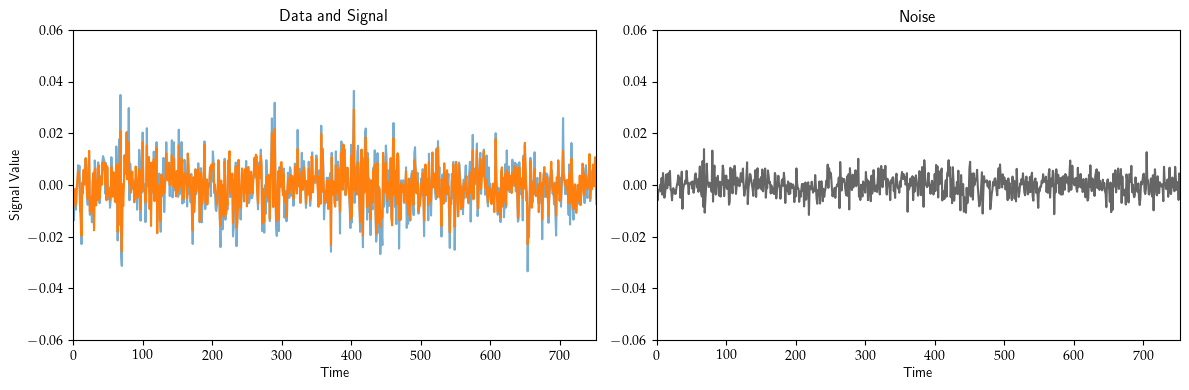

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(time, data, alpha=0.6)
plt.plot(time, signal)
plt.title('Data and Signal')
plt.xlabel("Time")
plt.ylabel("Signal Value")
plt.xlim(min(time), max(time))
plt.ylim(-0.06, 0.06)

plt.subplot(122)
plt.plot(time, noise, alpha=0.6, c = 'k')
plt.title('Noise')
plt.xlabel("Time")
plt.xlim(min(time), max(time))
plt.ylim(-0.06, 0.06)
plt.tight_layout()
# plt.savefig(f'plots/one_example_stock_fft.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

### Find Matrix A using FFT method

In [ ]:
def pre_process_fft(x_train: pd.DataFrame, ncomponents: int = 250, last_t: int = 504):
    """Performs FFT-based preprocessing on stock data to extract principal components and noise.

    Args:
        x_train (pd.DataFrame): A DataFrame of shape (50, 754) representing stock features,
            where 50 is the number of stocks and 754 is the number of time periods.
        ncomponents (int, optional): The number of Fourier components to retain. Defaults to 250.
        last_t (int, optional): The number of most recent time periods to keep after transformation.
            Defaults to 504.

    Returns:
        tuple: A tuple containing:
            - components (list of np.ndarray): A list of length 50, where each element is a
              (504, 250) array containing the extracted Fourier components for a stock.
            - record_noise (list of np.ndarray): A list of length 50, where each element is a
              (504,) array representing the residual noise for a stock.
    """

    # Number of stocks
    nstocks = x_train.shape[0]

    # Lists to store results
    components = []
    record_noise = []

    for i in range(nstocks):
        data = x_train.iloc[i].values  # Extract stock time series data
        component_signals, signal, noise = perform_fft(data, ncomponents)  # Apply FFT

        # Store the last 'last_t' time steps of the transformed components and noise
        components.append(component_signals[:, -last_t:].T)  # Shape: (504, 250)
        record_noise.append(noise[-last_t:])  # Shape: (504,)

    return components, record_noise


In [ ]:
# all_components: 50 arrays each of size (504, 250)
# all_noise: 50 arrays each of size (504,)
all_components, all_noise = pre_process_fft(X_train_df)

# (25200, 250)
X_features = np.vstack(all_components)

# (50, 50)
noise_cov = np.cov(all_noise)

# (250, 10)
A_fft = estimate_A_svd(X_features)

# (50, 504, 10)
factors_fft = np.asarray(np.split(X_features @ A_fft, noise_cov.shape[0]))

### One Stock Example

In [134]:
idx = 11
factor_one = factors_fft[idx]
target_one = Y_train.values[idx]
beta_one = np.linalg.inv(factor_one.T @ factor_one) @ factor_one.T @ target_one
pred_one = factor_one @ beta_one

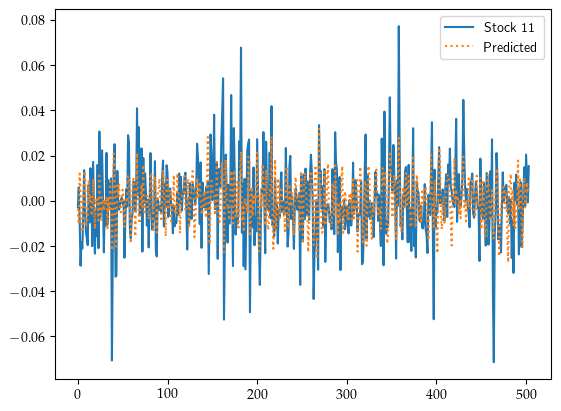

In [135]:
plt.plot(Y_train.values[idx], label = f'Stock {idx}')
plt.plot(pred_one, linestyle = ':', label = 'Predicted')
plt.legend()
plt.show()

## Likelihood 

$$
p(Y|\beta) = \prod_{i=1}^{50} \dfrac{1}{\sqrt{|2\pi\Sigma|}}\,\textrm{exp}[-\frac{1}{2}(Y_{i}-F_{i}\beta)^{\textrm{T}}\Sigma^{-1}(Y_{i}-F_{i}\beta)]
$$

In [ ]:
def model_fft(factors: jnp.ndarray,
              y_train: jnp.ndarray,
              noise_cov: jnp.ndarray,
              beta_width: float = 0.5) -> None:
    """Defines a Bayesian model using a multivariate normal likelihood with a normal prior on beta.

    Args:
        factors (jnp.ndarray): A tensor of shape (50, 504, 10) representing the factor loadings
            where 50 is the number of stocks, 504 is the number of time periods, and 10 is the
            number of latent factors.
        y_train (jnp.ndarray): A matrix of shape (50, 504) containing the observed stock returns.
        noise_cov (jnp.ndarray): A covariance matrix of shape (50, 50) representing the noise structure.
        beta_width (float, optional): The standard deviation of the normal prior on beta.
            Defaults to 0.5.

    Returns:
        None: This function defines a NumPyro probabilistic model but does not return a value.
    """

    nlatent = factors.shape[2]

    # Prior on beta (10-dimensional vector)
    beta = numpyro.sample("beta", dist.Normal(0, beta_width).expand([nlatent]))

    # Compute mean: F (50, 504, 10) @ beta (10,) -> (50, 504)
    mean_y = jnp.einsum("ijk,k->ij", factors, beta)

    # Likelihood: Multivariate Normal with given noise covariance
    numpyro.sample("Y", dist.MultivariateNormal(mean_y.T, noise_cov), obs=y_train.T)


In [21]:
NWARMUP = 500
NSAMPLES = 5000
NCHAIN = 2

In [22]:
nuts_kernel = NUTS(model_fft)

mcmc = MCMC(nuts_kernel,
            num_warmup=NWARMUP,
            num_samples=NSAMPLES,
            num_chains=NCHAIN,
            chain_method="vectorized")

mcmc.run(random.PRNGKey(randint(0, 1000)), factors_fft, Y_train.values, noise_cov)

sample: 100%|██████████| 5500/5500 [00:56<00:00, 97.34it/s] 


In [30]:
beta_samples = np.asarray(mcmc.get_samples()['beta'])[:,0:5]
ndim = beta_samples.shape[1]
names = ["x%s"%i for i in range(ndim)]
labels =  [r'$\beta_{1}$', r'$\beta_{2}$', r'$\beta_{3}$', r'$\beta_{4}$', r'$\beta_{5}$']
samples = MCSamples(samples=beta_samples, names = names, labels = labels)

Removed no burn in


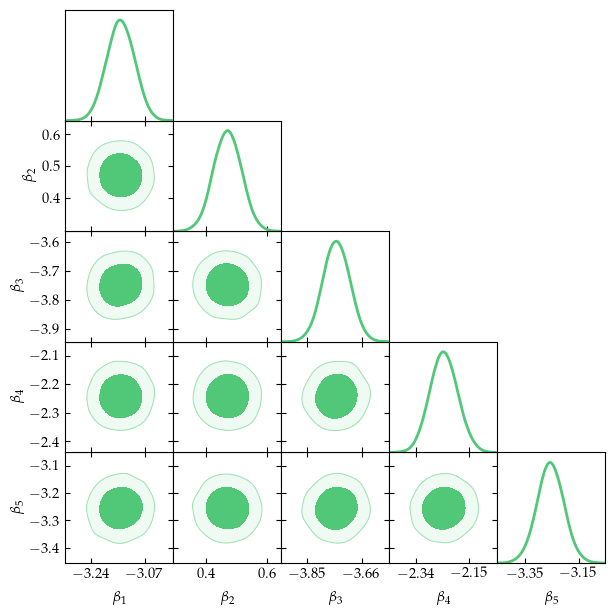

In [ ]:
color1 = "#50C878"
G = plots.getSubplotPlotter(subplot_size=1.25)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.5
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35
G.settings.legend_fontsize = 15
samples.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot([samples],
    filled=[True],
    contour_colors=[color1],
    contour_lws=[2],
    contour_ls=["-"],
)
# plt.savefig(f'plots/triangle_plot_fft.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

### Metric for FFT

In [ ]:
def calculate_metric_fft(matrix_A: np.ndarray,
                         beta_opt: np.ndarray,
                         factors: np.ndarray,
                         y_train: np.ndarray) -> float:
    """Calculate a similarity metric between predicted and true values.

    Args:
        matrix_A (np.ndarray): Orthonormal matrix of shape (250, 10).
        beta_opt (np.ndarray): Optimal beta values of shape (10,).
        factors (np.ndarray): Factor matrix of shape (50, 504, 10).
        y_train (np.ndarray): Target matrix of shape (50, 504).

    Returns:
        float: The calculated similarity metric, or -1.0 if the matrix is not orthonormal.
    """

    # Check orthonormality of matrix_A
    if not check_orthonormality(matrix_A):
        return -1.0

    # Step 2: (50, 504, 10) @ (10,) -> (50, 504)
    y_pred = np.einsum('ijk,k->ij', factors, beta_opt)  # (50, 504)

    # Normalize the true and predicted values (L2 normalization along each time)
    y_true_norm = y_train / np.linalg.norm(y_train, axis=0, keepdims=True)
    y_pred_norm = y_pred / np.linalg.norm(y_pred, axis=0, keepdims=True)

    # Compute cosine similarity (element-wise multiplication + mean)
    mean_overlap = np.mean(np.sum(y_true_norm * y_pred_norm, axis=0))

    return mean_overlap

In [88]:
samples_beta = np.asarray(mcmc.get_samples()['beta'])
beta_mean = np.mean(samples_beta, axis=0)

In [85]:
metrics_fft = [calculate_metric_fft(A_fft, beta_i, factors_fft, Y_train.values) for beta_i in samples_beta]

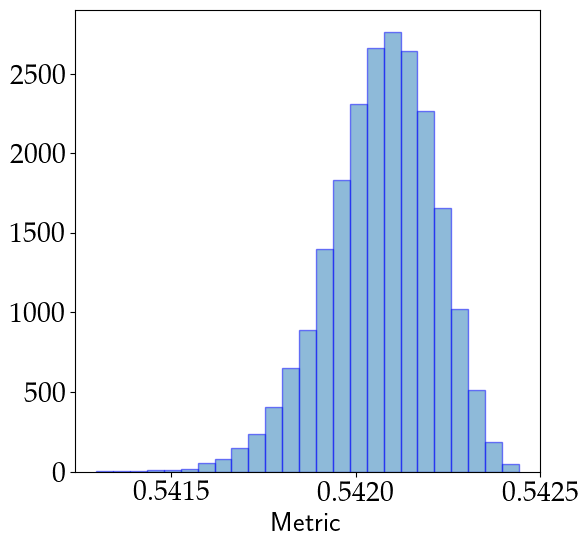

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(metrics_fft, density=True, alpha = 0.5, bins = 25, edgecolor="blue")
plt.xlabel('Metric', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
# plt.savefig(f'plots/metric_distribution_fft.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

In [113]:
# parameters_transform(A_fft, beta_mean, save=True, fname='submission_fft')